# Block coalescent

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
#devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(size=17)
                # text=element_text(family="Arial")
                ) 


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis



In [3]:
# remove.packages("ptdalgorithms")

In [4]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
# Rcpp::sourceCpp("./timeinhom-kingman.cpp")

In [8]:
source("plot_functions.R")

In [9]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

In [69]:
plot_sfs <- function(graph, rewards) {
    sfs <- apply(rewards, 1, function(x) expectation(graph, x))
    data.frame(
      ton=seq(1,length(sfs)),  
      brlen=sfs
      ) %>% ggplot(aes(x=ton, y=brlen, fill=ton)) + 
      geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + 
          scale_x_continuous(breaks = 1:(dim(rewards)[1])) +
          theme(legend.position = "none") + labs(x='nr descendants') +
          labs(y = "Total branch length", x = "Number of descendants") +
          despine
}
                 
get_cov_mat <- function(graph, rewards) {
    n <- nrow(rewards)
    cov_mat <- matrix(nrow=n,ncol=n)
    for (i in 1:(n)) {
        for (j in 1:(n)) {
            cov_mat[i, j] <- covariance(graph, rewards[i,], rewards[j,])
        }
    }
    return(cov_mat)
}
                  
plot_cov_mat <- function(cov_mat) {
   
    df <- as.data.frame(cov_mat)
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
    df$ton1 <- as.character(df$ton1)
    df$ton2 <- gsub("V","",as.character(df$ton2))
    df$ton1 <- factor(df$ton1, levels=unique(df$ton1[order(as.numeric(df$ton1))]))
    df$ton2 <- factor(df$ton2, levels=unique(df$ton2[order(as.numeric(df$ton2))]))
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

}

# Block coalescent

In [26]:
block_coalescent <- function(n) {
      
    state_vector_length <- 1 + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(0, 0)
    initial_state[1] <- n
    add_edge(starting_vertex, create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] == 1) {
        break
      }
      rate <- state[1] * (state[1] - 1) / 2
      child_state <- state
      child_state[1] <- child_state[1] - 1
      add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
      index <- index + 1
    }
    return(graph)
}

In [37]:
n <- 4
graph <- block_coalescent(n)
gam <- graph_as_matrix(graph)

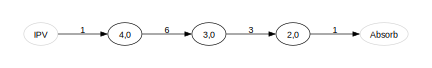

In [29]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

# SFS rewards for block coalescent

For exchangeable samples, these map between the tree levels we can model very effectively and the SFS we can observe

In [30]:
library("partitions")

lineage_partitions <- function(n) {
    p <- parts(n)
    return(apply(p, 2, function(x) {x[x!=0]}))
}
ton_counts <- function(p, n) {
    result <- rep(0, n)
    counts <- table(p)
    for (i in seq(n)) {
        c <- counts[names(counts)==i]
        if (length(c)) {
            result[i] <- c
        }
    }
    return(result)
}
multinom_coef <- function(params) {
    if (length(params) == 1) {
        return(1)
    }
    return(choose(sum(params), params[length(params)]) * multinom_coef(params[-length(params)]))
}
get_block_rewards <- function(n) {
    rewards <- matrix(0, n, n)
    for (p in lineage_partitions(n)) {
        counts <- ton_counts(p, n)
        rewards[length(p), ] <- rewards[length(p), ] + counts * multinom_coef(counts)
    }
    rewards <- rewards[-1, -ncol(rewards)]
    scale <- (2:n)/apply(rewards, 1, sum)
    rewards <- rewards * scale
    rewards <- t(rewards)[, ncol(rewards):1]
    rewards <- cbind(rep(0, nrow(rewards)), rewards, rep(0, nrow(rewards)))
    return(rewards)
}
n <- 4
rewards <- get_block_rewards(n)
rewards

0,4,2,0.6666667,0
0,0,1,0.6666667,0
0,0,0,0.6666667,0


Precompute rewards for a range of sample sizes:

In [31]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# # The following initializes usage of Bioc devel
# BiocManager::install(version='devel')

# BiocManager::install("rhdf5")

In [32]:
# library(rhdf5)
# # h5createFile("myhdf5file.h5")
# h5f = H5Fopen("myhdf5file.h5")

# h5closeAll()

In [33]:
# for (n in 80:100) {
#     start <- proc.time()[3]
#     rewards <- get_block_rewards(n)
#     end <- proc.time()[3]
#     print(c(n, (end - start)[['elapsed']]))
#     flush.console()
# }

In [34]:
library(parallel)

redo_sfs_rewards <- FALSE

if (redo_sfs_rewards) {
    v <- 3:60
    n <- as.list(v)
    names(n) <- v
    sfs_rewards <- mclapply(n, get_block_rewards, mc.cores=detectCores())
    saveRDS(sfs_rewards, file="sfs_rewards.RData")
} else {
    sfs_rewards <- readRDS(file="sfs_rewards.RData")
}

In [35]:
sfs_rewards[[as.character(4)]]

0,4,2,0.6666667,0
0,0,1,0.6666667,0
0,0,0,0.6666667,0


In [36]:
# rewards <- get_block_rewards(n)
# rewards

In [38]:
rewards <- sfs_rewards[[as.character(n)]]
sfs_expectation <- apply(rewards, 1, function(x) expectation(graph, x))
sfs_expectation

[1] 2.0000000 1.0000000 0.6666667

In [39]:
sfs_variance <- apply(rewards, 1, function(x) variance(graph, x))
sfs_variance

[1] 1.3333333 0.5555556 0.4444444

Compute the first `m` moments for each "ton" for `n` samples:

In [72]:
n <- 8
m <- 10
graph <- block_coalescent(n)
rewards <- sfs_rewards[[as.character(n)]]
sfs_moments <- data.frame(apply(rewards, 1, function(x) moments(graph, m, x)))
row.names(sfs_moments) <- 1:nr_moments
names(sfs_moments) <- 1:(n-1)
sfs_moments

,1,2,3,4,5,6,7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.000000e+00,1.000000,0.6666667,0.5000000,0.4000000,0.3333333,0.2857143
2,4.571429e+00,1.206349,0.5790476,0.3555102,0.2510658,0.1950113,0.1632653
3,1.175510e+01,1.714286,0.6293437,0.3361224,0.2216676,0.1678005,0.1399417
4,3.358601e+01,2.816974,0.8300391,0.4024233,0.2558018,0.1918954,0.1599334
5,1.055560e+02,5.273729,1.2967891,0.5880475,0.3666063,0.2741656,0.2284762
6,3.619063e+02,11.111957,2.3537585,1.0193923,0.6291395,0.4700066,0.3916735
7,1.344224e+03,26.083899,4.8848375,2.0501088,1.2587268,0.9400159,0.7833471
8,5.376894e+03,67.624569,11.4383549,4.6989110,2.8774309,2.1486089,1.7905076
9,2.304383e+04,192.200692,29.8838264,12.0995646,7.3994005,5.5249948,4.6041624


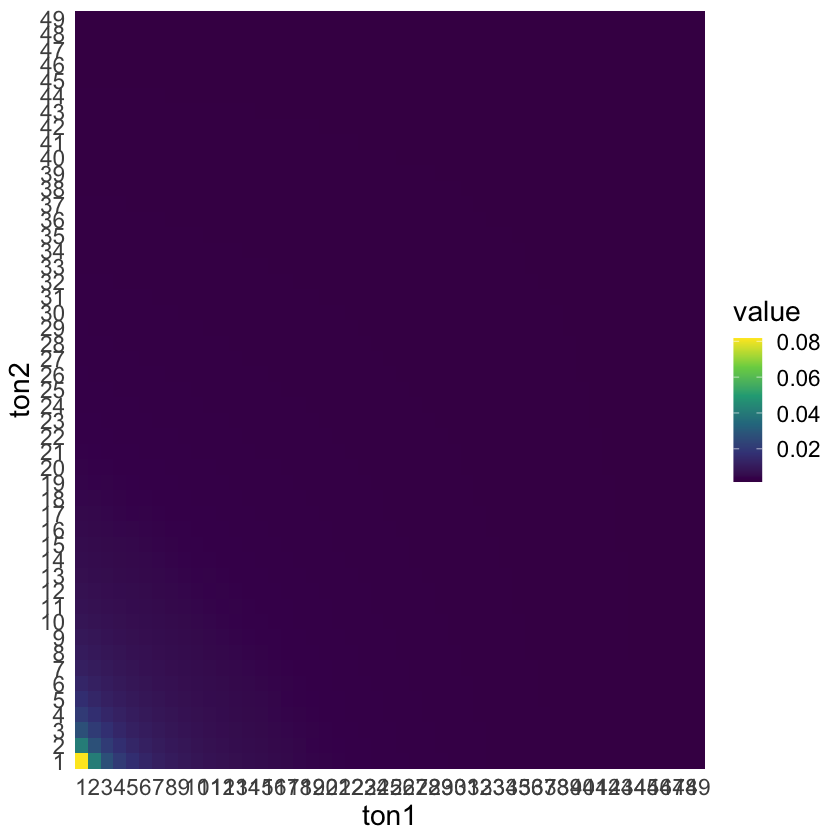

In [74]:
n <- 50
graph <- block_coalescent(n)
rewards <- sfs_rewards[[as.character(n)]]
plot_cov_mat(get_cov_mat(graph, rewards))

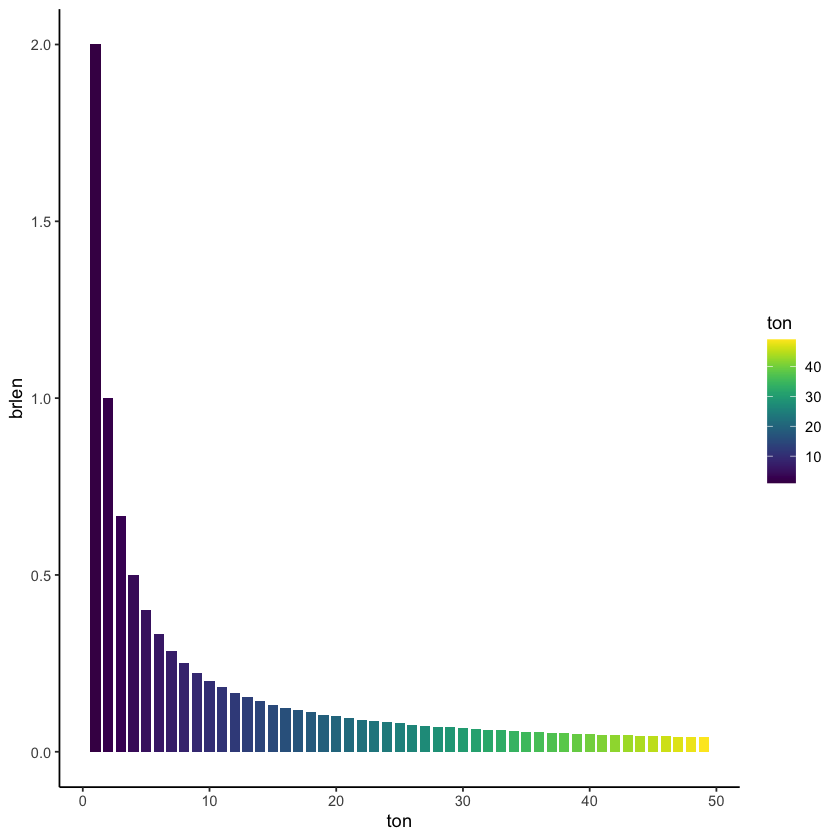

In [75]:

plot_sfs(graph, rewards) 
ggsave('~/Desktop/sfs.pdf', width=6, height=4) 